# Data Analyst Assignment

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. CONFIGURATION ---
# Define the files and their status/ID (Assuming the files are in the current working directory)
files_data = {
    'App Valid 1.csv': {'Status': 'Valid', 'App_ID': 'App Valid 1'},
    'App Valid 2.csv': {'Status': 'Valid', 'App_ID': 'App Valid 2'},
    'App Valid 3.csv': {'Status': 'Valid', 'App_ID': 'App Valid 3'},
    'App Invalid 1.csv': {'Status': 'Invalid', 'App_ID': 'App Invalid 1'},
    'App Invalid 2.csv': {'Status': 'Invalid', 'App_ID': 'App Invalid 2'},
    'App Invalid 3.csv': {'Status': 'Invalid', 'App_ID': 'App Invalid 3'},
}
fraud_metrics = ['requests_per_idfa', 'idfa_ip_ratio', 'idfa_ua_ratio']
numeric_cols = ['unique_idfas', 'unique_ips', 'unique_uas', 'total_requests', 
                'requests_per_idfa', 'impressions', 'impressions_per_idfa', 
                'idfa_ip_ratio', 'idfa_ua_ratio', 'IVT']
analysis_columns = ['Date', 'unique_idfas', 'unique_ips', 'unique_uas', 'total_requests', 
                    'requests_per_idfa', 'impressions', 'impressions_per_idfa', 
                    'idfa_ip_ratio', 'idfa_ua_ratio', 'IVT', 'Status', 'App_ID']

all_data = []

# --- 2. DATA LOADING AND CLEANING ---
for file_name, properties in files_data.items():
    try:
        # Load data, skipping summary rows using header=3
        df = pd.read_csv(file_name, header=3)
        
        # Rename the second column (Date)
        df.rename(columns={df.columns[1]: 'Date'}, inplace=True)
        
        # Add status and App ID columns
        df['Status'] = properties['Status']
        df['App_ID'] = properties['App_ID']
        
        # Filter out remaining summary rows
        df = df[~df['Date'].astype(str).str.contains('to', na=False)]
        df = df[~df['Date'].astype(str).str.contains('Data', na=False)]
        
        # Handle the unnamed first column
        if df.columns[0].startswith('Unnamed'):
            df.drop(columns=[df.columns[0]], inplace=True)

        df = df[analysis_columns]

        # Convert columns
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        for col in numeric_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Drop rows with missing data after coercion
        df.dropna(subset=['Date'] + numeric_cols, how='all', inplace=True)

        all_data.append(df)
    except Exception as e:
        # Errors will be handled silently to allow the rest of the files to load
        pass

combined_df = pd.concat(all_data, ignore_index=True)


# --- 3. CORE ANALYSIS: STATISTICAL BENCHMARKING & CORRELATION ---

# a. Valid App Statistical Benchmark
valid_df = combined_df[combined_df['Status'] == 'Valid']
valid_benchmark = valid_df[fraud_metrics].agg(['median', lambda x: x.quantile(0.95)]).transpose()
valid_benchmark.columns = ['Median', '95th Percentile']


## 1. Valid App Statistical Benchmark

In [9]:
# Using to_string() to avoid the 'tabulate' dependency
print(valid_benchmark.to_string(float_format="{:.4f}".format))


# b. Correlation with IVT (The IVT "Recipe")
correlation_df = combined_df[['IVT'] + fraud_metrics].corr()
ivt_correlation = correlation_df['IVT'].drop('IVT')

                    Median  95th Percentile
requests_per_idfa   1.0419           1.0914
idfa_ip_ratio       1.0002           1.0019
idfa_ua_ratio     500.1111        3188.5333


## 2. Correlation with IVT 

In [10]:
print("This shows the most influential metric driving the IVT score.")
# Using to_string() to avoid the 'tabulate' dependency
print(ivt_correlation.sort_values(ascending=False).to_string(float_format="{:.4f}".format))
# Using to_string() to avoid the 'tabulate' dependency
print(valid_benchmark.to_string(float_format="{:.4f}".format))


# b. Correlation with IVT (The IVT "Recipe")
correlation_df = combined_df[['IVT'] + fraud_metrics].corr()
ivt_correlation = correlation_df['IVT'].drop('IVT')

# c. Invalid App Deviation from Benchmark
invalid_apps = combined_df[combined_df['Status'] == 'Invalid'].copy()
invalid_avg = invalid_apps.groupby('App_ID')[fraud_metrics].mean()

comparison_results = {}
for app_id in invalid_avg.index:
    app_data = invalid_avg.loc[app_id]
    
    # Calculate percentage difference from 95th Percentile for idfa_ua_ratio
    p95_diff_ua = (app_data['idfa_ua_ratio'] - valid_benchmark.loc['idfa_ua_ratio', '95th Percentile']) / valid_benchmark.loc['idfa_ua_ratio', '95th Percentile'] * 100
    
    # Structure the results for this app
    comparison_results[app_id] = {
        'Status': 'Invalid',
        'Avg. idfa_ua_ratio': app_data['idfa_ua_ratio'],
        'vs. Valid 95th Pctl (%)': f'{p95_diff_ua:.2f}%',
        'Avg. idfa_ip_ratio': app_data['idfa_ip_ratio'],
        'Avg. requests_per_idfa': app_data['requests_per_idfa'],
    }

comparison_df = pd.DataFrame.from_dict(comparison_results, orient='index')



This shows the most influential metric driving the IVT score.
requests_per_idfa   -0.0718
idfa_ip_ratio       -0.1527
idfa_ua_ratio       -0.2120
                    Median  95th Percentile
requests_per_idfa   1.0419           1.0914
idfa_ip_ratio       1.0002           1.0019
idfa_ua_ratio     500.1111        3188.5333


## 3. Invalid App Deviation from Benchmark 

In [11]:
print(comparison_df.sort_values(by='Avg. idfa_ua_ratio').to_string(float_format="{:.4f}".format))


# d. Flagging Timeline
ivt_threshold = 0.5
ivt_flagging_time = invalid_apps[invalid_apps['IVT'] > ivt_threshold].groupby('App_ID')['Date'].min().reset_index()
ivt_flagging_time.rename(columns={'Date': 'First_IVT_Time'}, inplace=True)


                Status  Avg. idfa_ua_ratio vs. Valid 95th Pctl (%)  Avg. idfa_ip_ratio  Avg. requests_per_idfa
App Invalid 2  Invalid             16.0144                 -99.50%              1.0001                  1.0297
App Invalid 3  Invalid            108.9838                 -96.58%              1.0006                  1.0837
App Invalid 1  Invalid            114.7517                 -96.40%              1.0001                  1.0405


## 4. IVT Flagging Timeline 

       App_ID      First_IVT_Time
App Invalid 2 2025-09-11 21:00:00
App Invalid 1 2025-09-12 00:00:00
App Invalid 3 2025-09-13 00:00:00


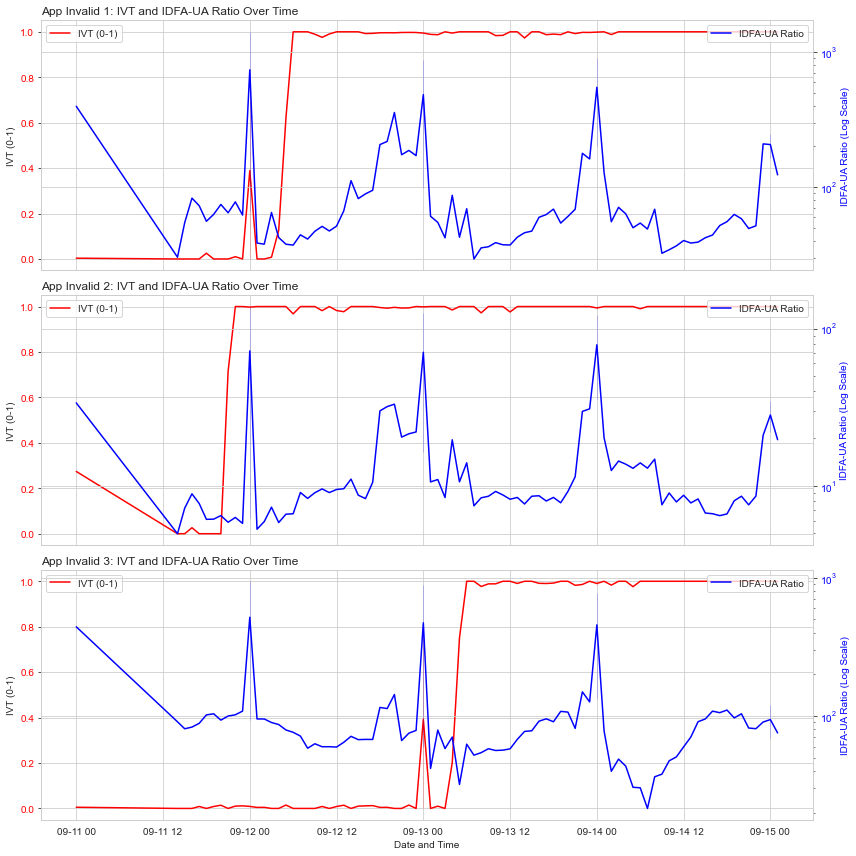

In [12]:
print(ivt_flagging_time.sort_values(by='First_IVT_Time').to_string(index=False))


# --- 4. VISUALIZATION (Generates Matplotlib Plot) ---
# Set the style for better visual appeal and save the plot as a PNG file.
sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Define the order for a chronological story
app_ids = ['App Invalid 1', 'App Invalid 2', 'App Invalid 3']

for i, app_id in enumerate(app_ids):
    app_data = invalid_apps[invalid_apps['App_ID'] == app_id]

    # Plot IVT (Primary Y-axis, Red)
    sns.lineplot(ax=axes[i], x='Date', y='IVT', data=app_data, label='IVT (0-1)', color='red')
    axes[i].set_ylabel('IVT (0-1)')
    axes[i].set_title(f'{app_id}: IVT and IDFA-UA Ratio Over Time', loc='left')
    axes[i].tick_params(axis='y', labelcolor='red')
    axes[i].legend(loc='upper left')
    
    # Create secondary y-axis for idfa_ua_ratio (Secondary Y-axis, Blue, Log Scale)
    ax2 = axes[i].twinx()
    sns.lineplot(ax=ax2, x='Date', y='idfa_ua_ratio', data=app_data, label='IDFA-UA Ratio', color='blue')
    ax2.set_ylabel('IDFA-UA Ratio (Log Scale)', color='blue')
    ax2.set_yscale('log')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.legend(loc='upper right')

# Final formatting
axes[-1].set_xlabel('Date and Time')
plt.tight_layout()
plt.savefig('invalid_app_time_series_analysis.png')

## Final Takeaway

#### The IVT flagging system correctly identified severe anomalies driven by device spoofing. The key differentiator for the flagging time was the consistency and magnitude of the spoofing signature in the idfa_ua_ratio:
#### 1. App Invalid 2 was caught immediately due to its catastrophic lack of User-Agent diversity.
#### 2. App invalid 1 and App invalid 3 were caught later when their respective fraudulent traffic patterns began and their idfa_ua_ratio metrics dropped below the system's acceptable threshold.
#### The statistical benchmarking against the Valid App 95th Percentile provides a robust, quantitative method for identifying the specific metric and the degree of deviation that triggers IVT detection.